In [742]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
import seaborn as sns
from rembg import remove


In [743]:
def resize_image(image, target_size):
    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]

    return resized_image

In [744]:
def insertGambar_list_only(folder):
    data = []
    filenames = []
    datalabel = []
    path = []

    for label in os.listdir(folder):
        folder_path = os.path.join(folder, label)
        images = os.listdir(folder_path)
        datalabel.append(label)
        print(f"Loading kategori: {label}")

        for filename in tqdm(images):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (100, 100))
                filenames.append(filename)
                path.append(label)
                data.append(img)

    return data, filenames, datalabel, path


In [745]:

data, filenames, label, path, distribusi, datakategori = insertGambar("Dataset/")
print("Total Data:", len(data))
print("Label unik:", label)
print("Distribusi data:", distribusi)


Loading kategori: Cyttaria_espinosae


100%|██████████| 32/32 [00:01<00:00, 16.70it/s]


Loading kategori: Morchella_esculenta


100%|██████████| 58/58 [00:02<00:00, 21.31it/s]

Total Data: 90
Label unik: ['Cyttaria_espinosae', 'Morchella_esculenta']
Distribusi data: {'Cyttaria_espinosae': 32, 'Morchella_esculenta': 58}


In [746]:
def display_sample(datakategori):
    for kategori, data in datakategori.items():
        print(f"Menampilkan sample untuk kategori: {kategori}")
        images = [img for _, img in data]
        plt.figure(figsize=(20, 3))
        for i in range(min(7, len(images))):
            plt.subplot(1, 7, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if len(images[i].shape) == 2:  # grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
        plt.suptitle(f"Kategori: {kategori}")
        plt.show()

Menampilkan sample untuk kategori: Cyttaria_espinosae


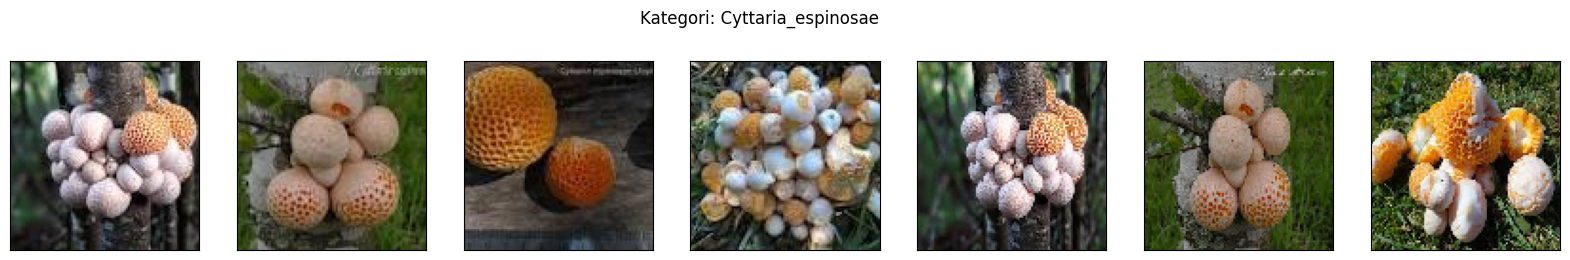

Menampilkan sample untuk kategori: Morchella_esculenta


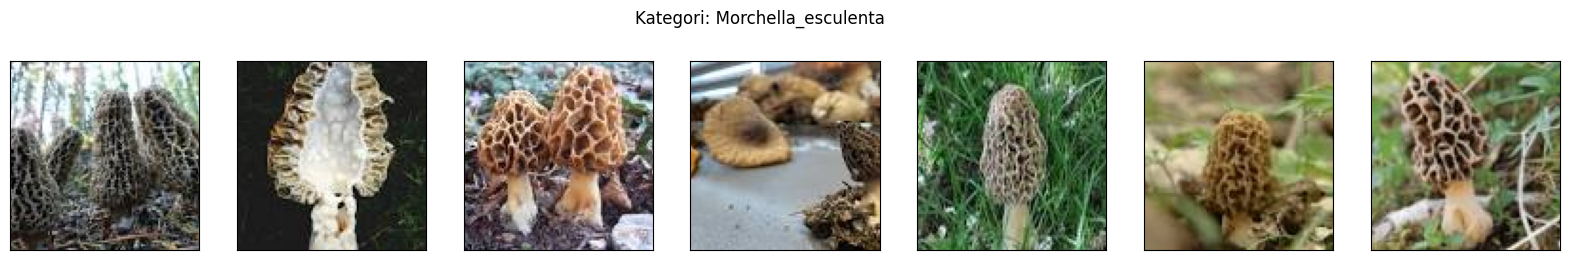

In [747]:
display_sample(datakategori)

In [748]:
def removeBackgroundByCategory(data):
    removed_data = {}

    for kategori, items in data.items():
        removed_list = []
        for filename, img in tqdm(items, desc=f"remove background {kategori}"):
            img_removed = remove(img) 
            removed_list.append((filename, img_removed))
        removed_data[kategori] = removed_list

    return removed_data


In [749]:
removej = removeBackgroundByCategory(datakategori)  # pertama remove background

def gray_scaling(data):
    gray_data = {}

    for kategori, items in data.items():
        gray_list = []
        for filename, img in tqdm(items, desc=f"grayscaling {kategori}"):
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            gray_list.append((filename, gray))  
        gray_data[kategori] = gray_list

    return gray_data

grayj = gray_scaling(removej)  # kemudian grayscale


grayscaling Morchella_esculenta: 100%|██████████| 58/58 [00:00<00:00, 10865.59it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


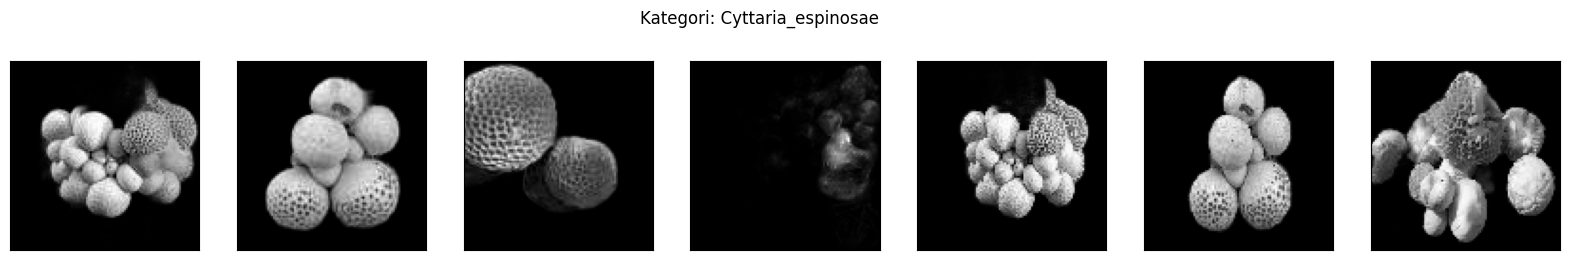

Menampilkan sample untuk kategori: Morchella_esculenta


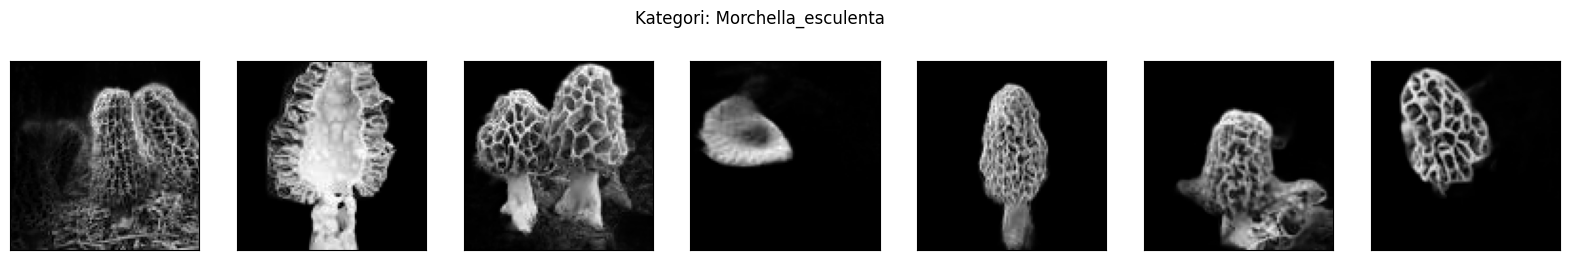

In [750]:
display_sample(grayj)

gray_images = []

for kategori in grayj:
    for filename, img in grayj[kategori]:
        gray_images.append(img)

Median Morchella_esculenta: 100%|██████████| 58/58 [00:03<00:00, 14.58it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


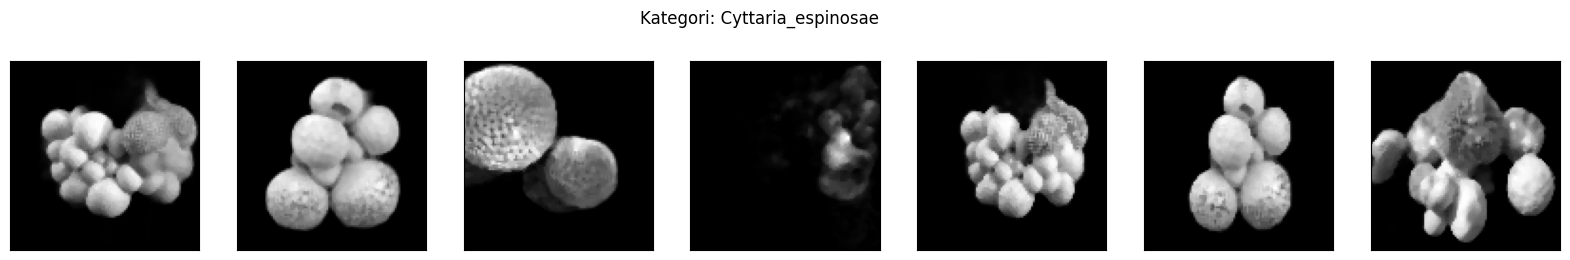

Menampilkan sample untuk kategori: Morchella_esculenta


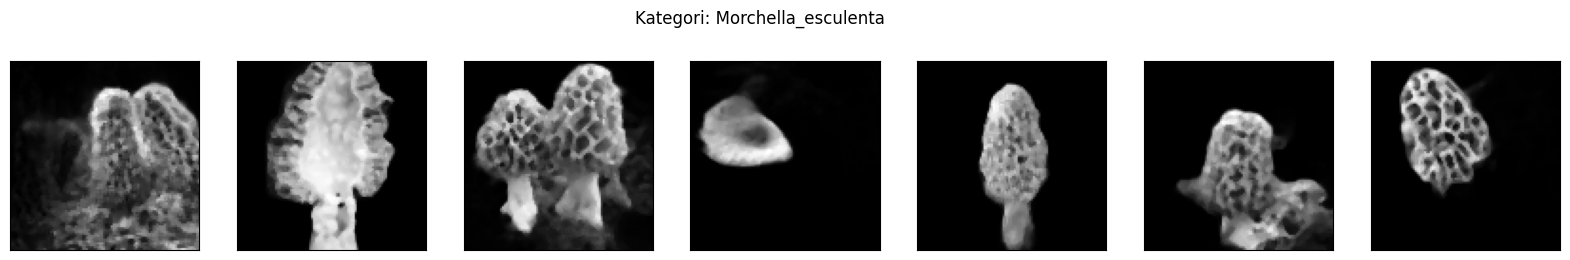

In [751]:
def median(image, ksize=3):
    assert ksize % 2 == 1
    pad = ksize // 2
    padded_img = np.pad(image, pad, mode='edge')
    h, w = image.shape
    filtered_img = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            window = []
            for m in range(-pad, pad + 1):
                for n in range(-pad, pad + 1):
                    val = padded_img[i + pad + m, j + pad + n]
                    window.append(int(val))

            window.sort()
            median_val = window[len(window) // 2]
            filtered_img[i, j] = median_val

    return filtered_img

def apply_manual_median_filter(data, ksize=3):
    filtered_data = {}

    for kategori, items in data.items():
        filtered_list = []
        for filename, img in tqdm(items, desc=f"Median {kategori}"):
            filtered_img = median(img, ksize)
            filtered_list.append((filename, filtered_img))
        filtered_data[kategori] = filtered_list

    return filtered_data

medianimg = apply_manual_median_filter(grayj)
display_sample(medianimg)

gray_images = []

for kategori in medianimg:
    for filename, img in medianimg[kategori]:
        gray_images.append(img)


Sharpening Morchella_esculenta: 100%|██████████| 58/58 [00:00<00:00, 2846.46it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


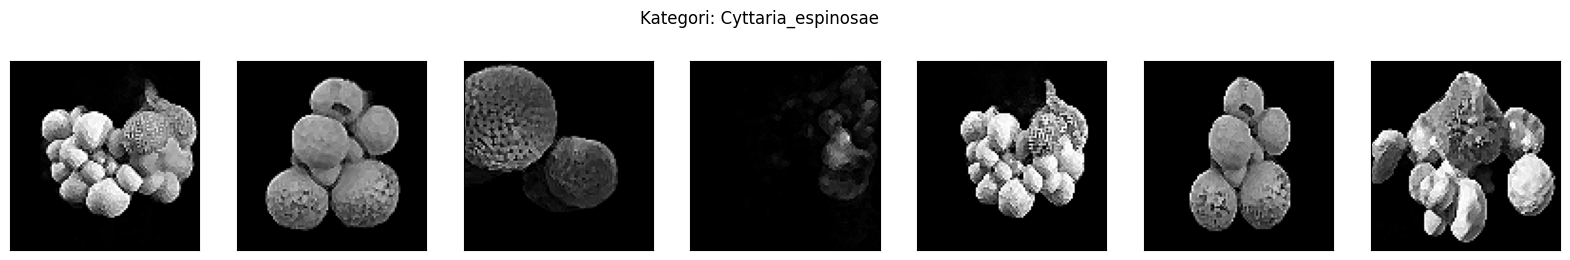

Menampilkan sample untuk kategori: Morchella_esculenta


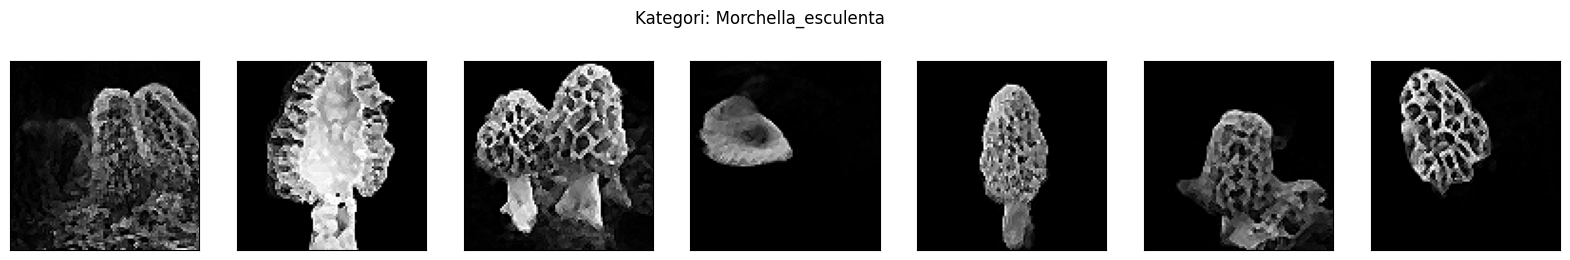

In [785]:
def sharpening_filter(img):
    # Kernel sharpening sederhana
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    
    # Terapkan kernel dengan filter2D dari OpenCV
    sharpened = cv.filter2D(img, -1, kernel)
    return sharpened
def apply_sharpening_filter(data_dict):
    sharpened_data = {}
    for kategori, items in data_dict.items():
        sharpened_list = []
        for filename, img in tqdm(items, desc=f"Sharpening {kategori}"):
            sharpened_img = sharpening_filter(img)
            sharpened_list.append((filename, sharpened_img))
        sharpened_data[kategori] = sharpened_list
    return sharpened_data

sharpened_result = apply_sharpening_filter(medianimg)  # atau medianimg, atau graypcos
display_sample(sharpened_result)

gray_images = []
for kategori in sharpened_result:
    for filename, img in sharpened_result[kategori]:
        gray_images.append(img)


Thresholding Morchella_esculenta: 100%|██████████| 58/58 [00:00<00:00, 122.64it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


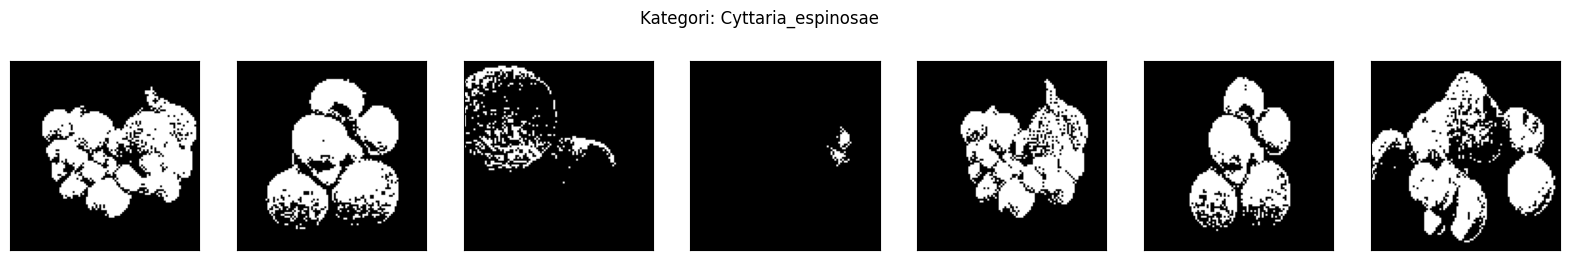

Menampilkan sample untuk kategori: Morchella_esculenta


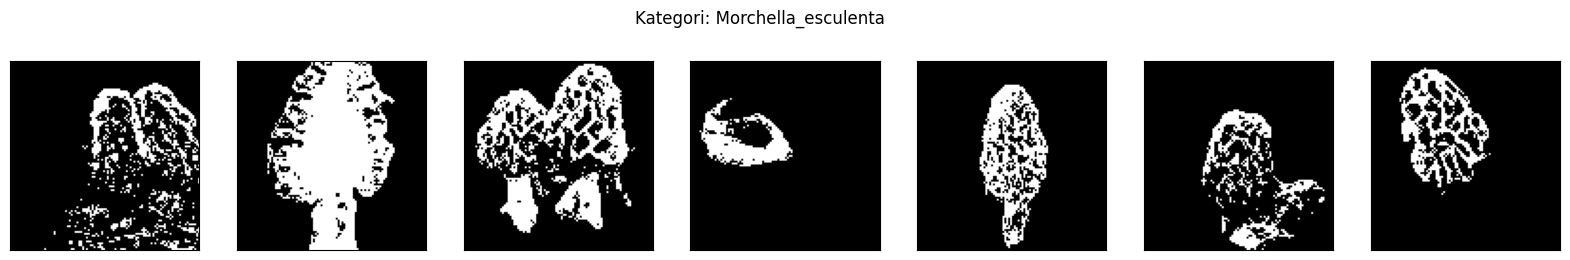

In [813]:
def apply_threshold(image, threshold=100):
    # Buat output biner: pixel > threshold jadi 255, selainnya 0
    binary_img = np.zeros_like(image, dtype=np.uint8)
    rows, cols = image.shape
    for r in range(rows):
        for c in range(cols):
            binary_img[r, c] = 255 if image[r, c] > threshold else 0
    return binary_img

def apply_threshold_to_data(data_dict, threshold=100):
    thresholded_data = {}
    for kategori, items in data_dict.items():
        thresholded_list = []
        for filename, img in tqdm(items, desc=f"Thresholding {kategori}"):
            bin_img = apply_threshold(img, threshold)
            thresholded_list.append((filename, bin_img))
        thresholded_data[kategori] = thresholded_list
    return thresholded_data

threshold_value = 100
thresholded_images = apply_threshold_to_data(sharpened_result, threshold=threshold_value)

display_sample(thresholded_images)

# Jika mau ambil jadi list biasa
gray_images = []
for kategori in thresholded_images:
    for filename, img in thresholded_images[kategori]:
        gray_images.append(img)


In [814]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [815]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [816]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [817]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [818]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [819]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [820]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [821]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [822]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(gray_images)):
    D0 = glcm(gray_images[i], 0)
    D45 = glcm(gray_images[i], 45)
    D90 = glcm(gray_images[i], 90)
    D135 = glcm(gray_images[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [823]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [824]:
for i in range(len(gray_images)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [825]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [826]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [827]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [828]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [829]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [830]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [831]:
label = [1] * 100 + [0] * 100
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,Cyttaria_espinosae0.png,Cyttaria_espinosae,5188.863636,5718.962351,5215.136364,5718.962351,0.920203,0.912051,0.919799,0.912051,...,0.514600,0.505711,0.717593,0.711133,0.717356,0.711133,0.806142,0.787598,0.805160,0.787598
1,Cyttaria_espinosae1.png,Cyttaria_espinosae,4978.681818,5811.845730,5018.090909,5891.460055,0.923436,0.910623,0.922829,0.909398,...,0.518261,0.504635,0.720260,0.711083,0.719904,0.710377,0.813492,0.783572,0.812016,0.780607
2,Cyttaria_espinosae10.png,Cyttaria_espinosae,4676.545455,5228.007346,5004.954545,5533.195592,0.928082,0.919601,0.923031,0.914908,...,0.788918,0.782024,0.891301,0.886533,0.888211,0.884321,0.481984,0.426220,0.450361,0.392725
3,Cyttaria_espinosae11.png,Cyttaria_espinosae,472.909091,398.071625,446.636364,398.071625,0.992727,0.993878,0.993131,0.993878,...,0.977744,0.978326,0.988608,0.989104,0.988809,0.989104,0.528803,0.607304,0.554980,0.607304
4,Cyttaria_espinosae12.png,Cyttaria_espinosae,5596.090909,5692.424242,4991.818182,5904.729109,0.913941,0.912459,0.923234,0.909194,...,0.565273,0.551077,0.746654,0.744150,0.751846,0.742346,0.763474,0.761050,0.789015,0.752138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Morchella_esculenta69.png,Morchella_esculenta,2049.272727,2123.048669,1734.000000,2282.277319,0.968485,0.967351,0.973334,0.964902,...,0.849775,0.840699,0.919352,0.918141,0.921832,0.916897,0.746396,0.739706,0.785412,0.720184
86,Morchella_esculenta70.png,Morchella_esculenta,5438.454545,5984.343434,4492.636364,5785.307622,0.916365,0.907970,0.930910,0.911031,...,0.723715,0.705133,0.843440,0.838228,0.850715,0.839722,0.605428,0.569568,0.674049,0.583884
87,Morchella_esculenta71.png,Morchella_esculenta,3389.181818,3781.680441,2640.409091,3516.299357,0.947880,0.941844,0.959395,0.945925,...,0.805074,0.791452,0.891418,0.887597,0.897259,0.889636,0.665823,0.630504,0.739653,0.656433
88,Morchella_esculenta8.png,Morchella_esculenta,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

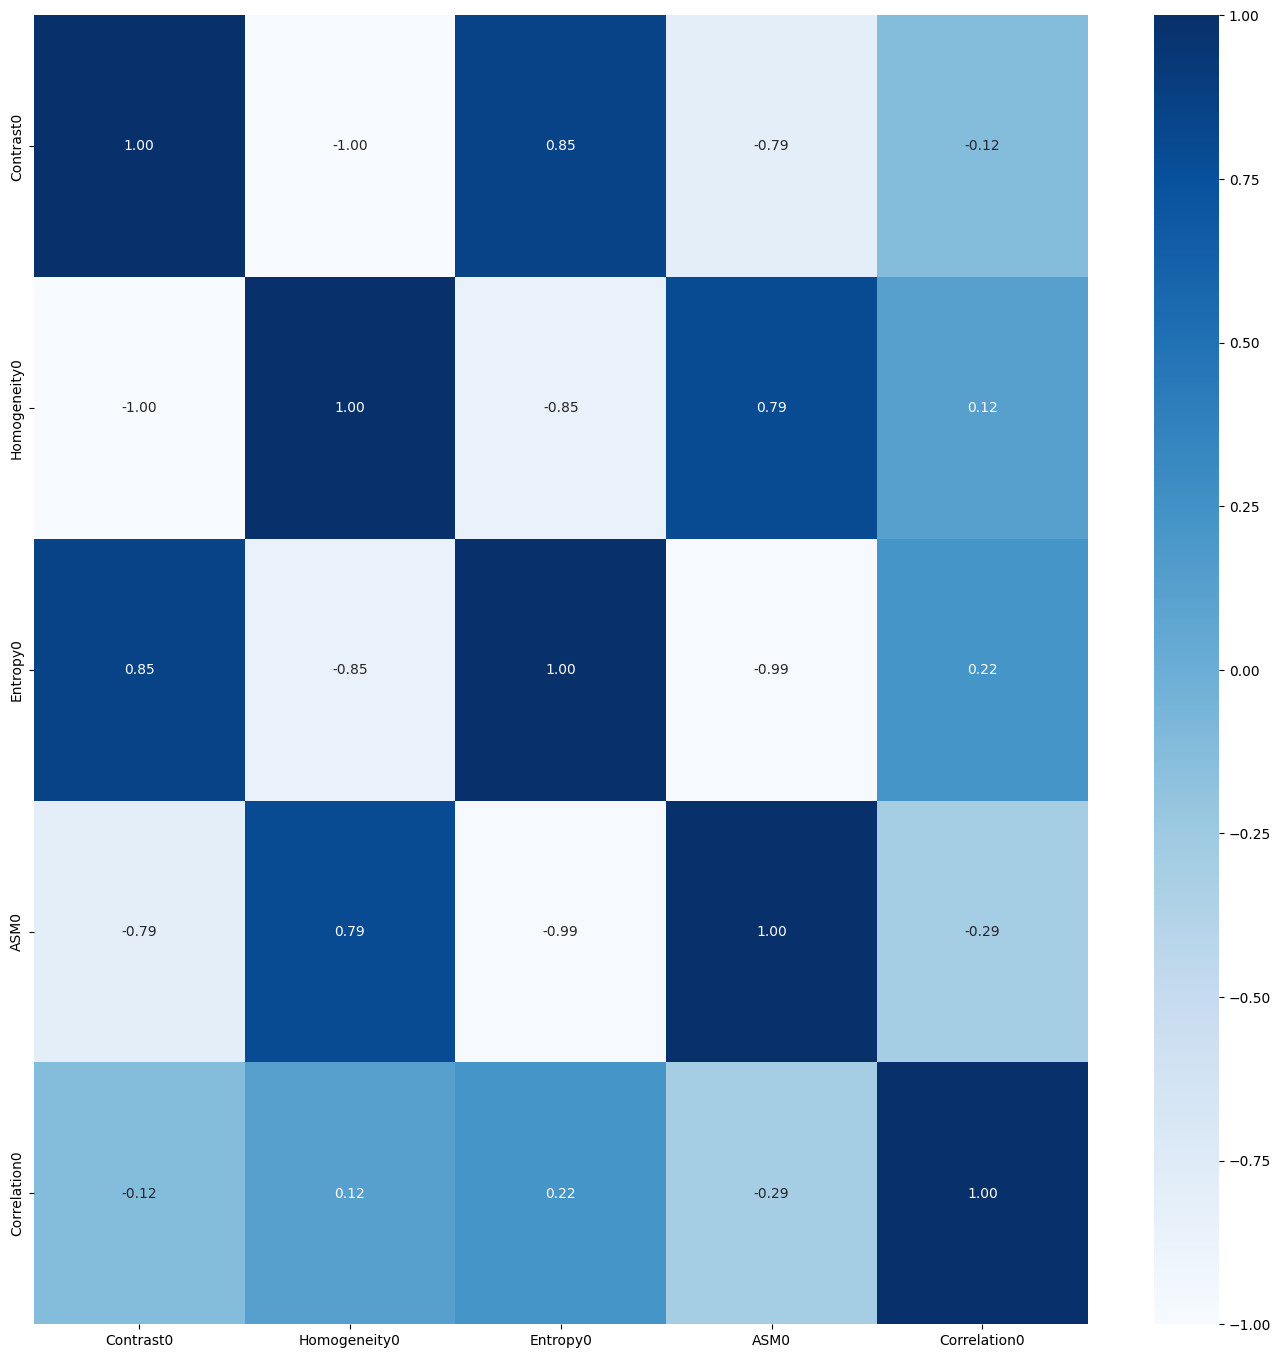

In [832]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [833]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(72, 5)
(18, 5)


In [834]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [835]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)


In [836]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.95      0.83      0.89        24
Morchella_esculenta       0.92      0.98      0.95        48

           accuracy                           0.93        72
          macro avg       0.94      0.91      0.92        72
       weighted avg       0.93      0.93      0.93        72

[[20  4]
 [ 1 47]]
Accuracy: 0.9305555555555556

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.88      0.88      0.88         8
Morchella_esculenta       0.90      0.90      0.90        10

           accuracy                           0.89        18
          macro avg       0.89      0.89      0.89        18
       weighted avg       0.89      0.89      0.89        18

[[7 1]
 [1 9]]
Accuracy: 0.8888888888888888


In [837]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.67      0.50      0.57        24
Morchella_esculenta       0.78      0.88      0.82        48

           accuracy                           0.75        72
          macro avg       0.72      0.69      0.70        72
       weighted avg       0.74      0.75      0.74        72

[[12 12]
 [ 6 42]]
Accuracy: 0.75

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       1.00      0.62      0.77         8
Morchella_esculenta       0.77      1.00      0.87        10

           accuracy                           0.83        18
          macro avg       0.88      0.81      0.82        18
       weighted avg       0.87      0.83      0.82        18

[[ 5  3]
 [ 0 10]]
Accuracy: 0.8333333333333334


In [838]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.70      0.67      0.68        24
Morchella_esculenta       0.84      0.85      0.85        48

           accuracy                           0.79        72
          macro avg       0.77      0.76      0.76        72
       weighted avg       0.79      0.79      0.79        72

[[16  8]
 [ 7 41]]
Accuracy: 0.7916666666666666

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.86      0.75      0.80         8
Morchella_esculenta       0.82      0.90      0.86        10

           accuracy                           0.83        18
          macro avg       0.84      0.82      0.83        18
       weighted avg       0.84      0.83      0.83        18

[[6 2]
 [1 9]]
Accuracy: 0.8333333333333334
